In [11]:
import os
import numpy as np
import pandas as pd 
import itertools as it

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

# set project dir
from project_utils.envtools import set_project_dir
set_project_dir()

# set output dir
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/'
os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

## Load the data

In [2]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.250_prots.npq.tsv", sep="\t")
protein_data = protein_data.T

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# keep the a virtual backup of the main clinical and protein data
backup_clinical_data = clinical_data.copy()
backup_protein_data = protein_data.copy()

# remove just visit 1 samples
keep = (clinical_data.event_name == 1.0).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs,:]

# # Load the protein levels data
# protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.250_prots.npq.tsv", sep="\t")
# protein_data = protein_data.T

# # extract triplet
# protein_data = protein_data.loc[:,:]

# # Load the clinical data
# clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# # remove alamar samples
# keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
# clinical_data = clinical_data.loc[keep,:]
# protein_data = protein_data.loc[keep,:]

# # extract just CD and UC data
# focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
# # commented out on purpose, need all samples 
# clinical_data = clinical_data.iloc[focus_idxs]
# protein_data = protein_data.iloc[focus_idxs]

In [3]:
protein_data.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662


In [4]:
clinical_data.head()

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild


In [5]:
clinical_data.loc[clinical_data['matched_subject_id'] == 20]

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity


In [6]:
select_n = 14

# load the model results
fn = os.path.join(outdir, f'logit_model.rfe_{select_n}_proteins.coefs.xlsx')
logit_model_coefs = pd.read_excel(fn)
selected_features_list = logit_model_coefs.protein.tolist()

In [7]:
# load the leave one out results
fn = os.path.join(outdir, f'leave_one_out_validation.rfe{select_n}.tsv')
results_loo_df = pd.read_table(fn)

### Diving into misclassifications for the LOO samples during training (V1 Samples Only)

In [8]:
tdf = results_loo_df.copy()
tdf.index = protein_data.index.tolist()
full_data = pd.concat([protein_data, tdf], axis=1)

# extract incorrect samples
incorrect_data = full_data.loc[full_data['match'] == False]

In [12]:
# Run PCA
pca = PCA(n_components=10)
#principal_components = pca.fit_transform(protein_data)
principal_components = pca.fit_transform(protein_data.loc[:, selected_features_list])

# make into a dataframe
principal_components = pd.DataFrame(principal_components, columns=[f'pc{x}' for x in range(1,11)])

# add the index
principal_components.index = protein_data.index.tolist()

# add the clinical info
#principal_components['matched_subject_id'] = clinical_data.matched_subject_id.astype(str).values.tolist()
principal_components = pd.concat([principal_components, clinical_data.set_index('sample_id')], axis=1)

# add prediction information
principal_components['matched_predictions'] = results_loo_df['match'].values.tolist()

# add subject error color depending on subjects that have at least one messed up sample
subject_with_errs = principal_components.groupby('matched_subject_id').matched_predictions.apply(lambda v: (~v).sum())
subject_with_errs = subject_with_errs[subject_with_errs > 0] 
principal_components['subject_err_color'] = principal_components.matched_subject_id.apply(lambda x: x if x in subject_with_errs.index.tolist() else 'other')

In [13]:
# get the error subjects and their counts for number of samples
subjects_with_err = principal_components[principal_components.matched_subject_id.isin(subject_with_errs.index.tolist())].matched_subject_id.value_counts()
subjects_with_err = subjects_with_err.to_frame()
subjects_with_err.sort_values('matched_subject_id', key=lambda vals: [float(v) for v in vals])

,count
matched_subject_id,
1.0,1
7.0,1


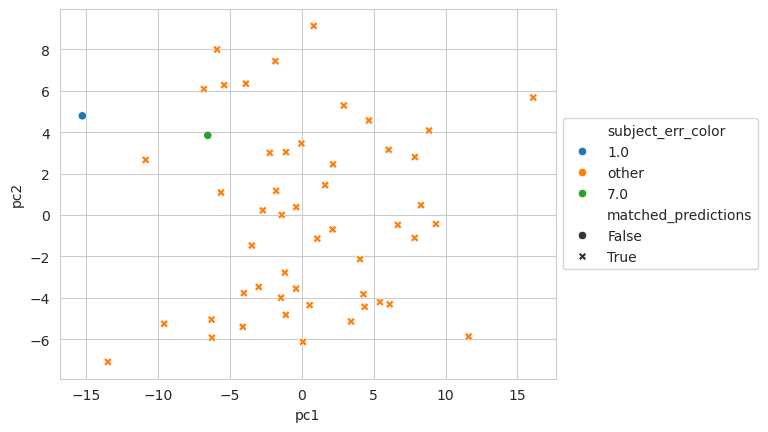

In [14]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_err_color', style='matched_predictions', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfn = os.path.join(outdir, f'pca.with_selected_features.rfe{select_n}.subject_colored.svg')
fig.savefig(outfn)

In [15]:
outfn

'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/pca.with_selected_features.rfe14.subject_colored.svg'

In [16]:
from matplotlib.colors import ListedColormap

# Define your custom colors in hex
hex_colors = ['#FF5733', '#3357FF', '#FFC300']

# Create the ListedColormap
custom_cmap = ListedColormap(hex_colors, name='my_custom_cmap')

/tmp/ipykernel_1257482/898986874.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(y='pc2', x='pc1', hue='ibd_diagnosis', style='matched_predictions', palette=hex_colors, data=principal_components, ax=ax)


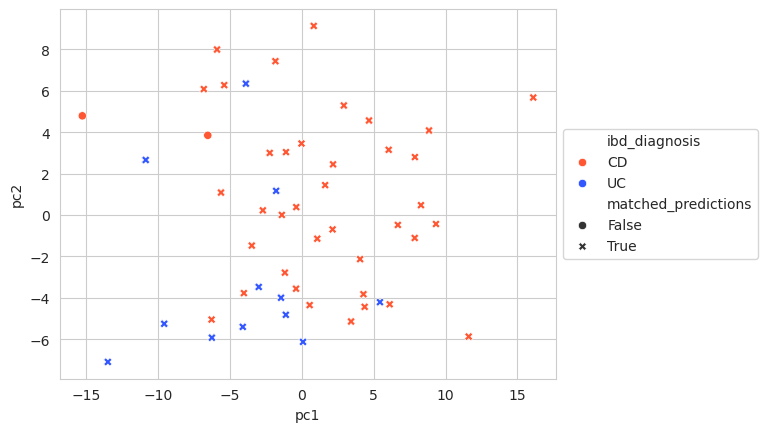

In [17]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(y='pc2', x='pc1', hue='ibd_diagnosis', style='matched_predictions', palette=hex_colors, data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfn = os.path.join(outdir, f'pca.with_selected_features.rfe{select_n}.ibd_diagnosis_colored.svg')
fig.savefig(outfn, bbox_inches='tight')

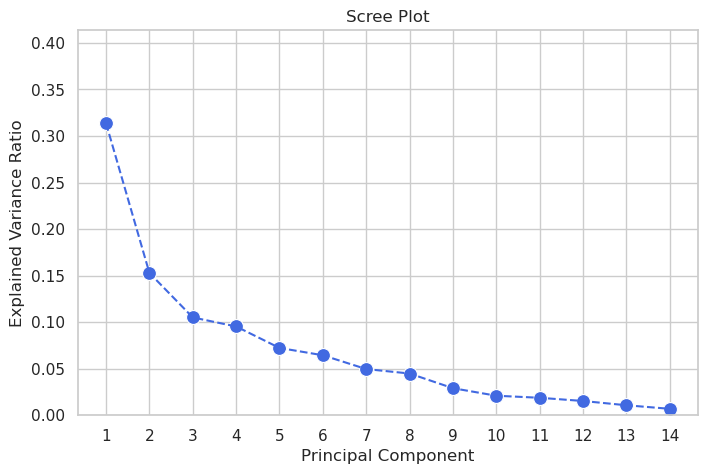

In [18]:
pca = PCA()
pca.fit(protein_data.loc[:, selected_features_list])

# Create a DataFrame for plotting
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)

df = pd.DataFrame({
    'Principal Component': components,
    'Explained Variance': explained_variance
})

# Set Seaborn theme
sns.set(style="whitegrid")

# Scree plot using seaborn.scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Principal Component', y='Explained Variance', color='royalblue', s=100)
plt.plot(df['Principal Component'], df['Explained Variance'], color='royalblue', linestyle='dashed')  # connect the dots

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components)
plt.ylim(0, max(explained_variance) + 0.1)
plt.show()

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

def scatterplot_3d(x, y, z, hue=None, data=None, palette='viridis',
                   xlabel='X', ylabel='Y', zlabel='Z', title='3D Scatter Plot',
                   figsize=(8,6), legend_title='Legend'):
    """
    3D scatter plot similar to seaborn.scatterplot()

    Parameters:
    - x, y, z: str (column names) or array-like
    - hue: str (column name) or array-like for color grouping (optional)
    - data: pandas DataFrame (if using column names)
    - palette: colormap name (default: 'viridis')
    - xlabel, ylabel, zlabel, title: axis labels and title
    - figsize: figure size
    - legend_title: title for the legend
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # If data is provided and x/y/z/hue are strings, extract values
    if data is not None:
        x_vals = data[x]
        y_vals = data[y]
        z_vals = data[z]
        hue_vals = data[hue] if hue is not None else None
    else:
        x_vals, y_vals, z_vals = x, y, z
        hue_vals = hue

    # If hue is given, handle coloring and legend
    if hue_vals is not None:
        unique_labels = sorted(set([str(x) for x in hue_vals]))
        #cmap = plt.get_cmap(palette, len(unique_labels))
        cmap = palette
        
        for i, label in enumerate(unique_labels):
            mask = hue_vals == label
            ax.scatter(x_vals[mask], y_vals[mask], z_vals[mask],
                       color=cmap(i), label=label)
        ax.legend(title=legend_title)
    else:
        ax.scatter(x_vals, y_vals, z_vals, c='blue')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.show()

def scatterplot_3d_style(x, y, z, hue=None, style=None, data=None, palette='viridis',
                   xlabel='X', ylabel='Y', zlabel='Z', title='3D Scatter Plot',
                   figsize=(8,6), legend_title='Legend', elev=30, azim=-60):
    """
    3D scatter plot similar to seaborn.scatterplot(), with hue and marker style.

    Parameters:
    - x, y, z: str (column names) or array-like
    - hue: str (column name) or array-like for color grouping (optional)
    - style: str (column name) or array-like for marker styles (optional)
    - data: pandas DataFrame (if using column names)
    - palette: colormap name (default: 'viridis')
    - xlabel, ylabel, zlabel, title: axis labels and title
    - figsize: figure size
    - legend_title: title for the legend
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)


    # If data is provided and x/y/z/hue/style are strings, extract values
    if data is not None:
        x_vals = data[x]
        y_vals = data[y]
        z_vals = data[z]
        hue_vals = data[hue] if hue is not None else None
        style_vals = data[style] if style is not None else None
    else:
        x_vals, y_vals, z_vals = x, y, z
        hue_vals = hue
        style_vals = style

    # Prepare unique values
    unique_hues = sorted(set([str(x) for x in hue_vals])) if hue_vals is not None else [None]
    unique_styles = sorted(set([str(s) for s in style_vals])) if style_vals is not None else [None]

    # Define color map and marker list
    #cmap = plt.get_cmap(palette).ashex()[len(unique_hues)]
    cmap = palette
    marker_list = ['o', '*', 's', '^', 'D', 'P', 'X', 'v']  # extend as needed

    # Plot points grouped by hue and style
    for i, hue_label in enumerate(unique_hues):
        for j, style_label in enumerate(unique_styles):
            mask = np.ones(len(x_vals), dtype=bool)
            if hue_vals is not None:
                mask &= (np.array([str(x) for x in hue_vals]) == hue_label)
            if style_vals is not None:
                mask &= (np.array([str(s) for s in style_vals]) == style_label)
            
            if np.any(mask):  # only plot if any points match
                ax.scatter(
                    x_vals[mask], y_vals[mask], z_vals[mask],
                    color=cmap(i),
                    marker=marker_list[j % len(marker_list)],
                    label=f"{hue_label}, {style_label}" if hue_vals is not None and style_vals is not None else
                          f"{hue_label}" if hue_vals is not None else
                          f"{style_label}" if style_vals is not None else "Data"
                )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys(), title=legend_title)

    plt.show()

    return(ax)


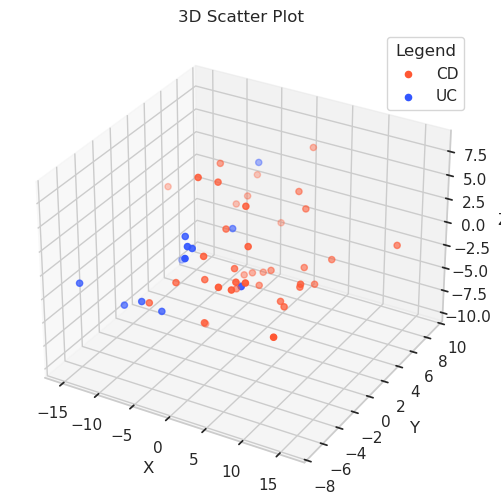

In [20]:
scatterplot_3d('pc1', 'pc2', 'pc3', hue='ibd_diagnosis', palette=custom_cmap, data=principal_components)

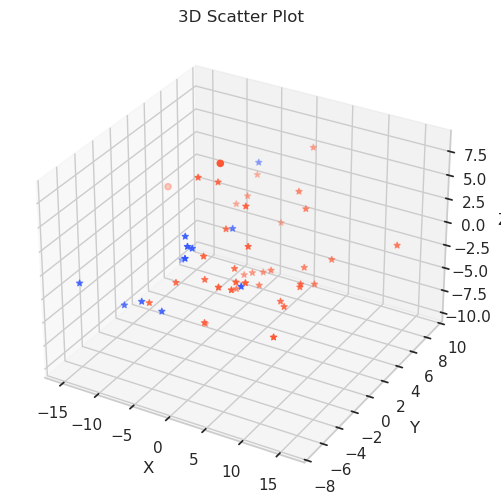

<Axes3D: title={'center': '3D Scatter Plot'}, xlabel='X', ylabel='Y', zlabel='Z'>

In [21]:
scatterplot_3d_style('pc1', 'pc2', 'pc3', hue='ibd_diagnosis', style='matched_predictions',
                     data=principal_components, palette=custom_cmap)

### Merge the data for manual investigation

In [19]:
samples_with_annot = principal_components.merge(clinical_data, left_index=True, right_on='original_subject_id', suffixes=(None, '_y'))
samples_with_annot = samples_with_annot.iloc[:, ~samples_with_annot.columns.str.contains('_y$')]

cols = ['matched_subject_id', 'sample_id', 'subject_err_color', 'matched_predictions', 'pc1', 'pc2', 'project_name',
        'sample_type', 'collection_date', 'box_id', 'box_location', 'total_volume__ml', 'original_subject_id',
        'event_name', 'ibd_diagnosis', 'date_collection', 'disease_activity', 'notes', 'ibd_indicator',
        'disease_activity_indicator', 'max_crp_value', 'crp_severity']
samples_with_annot = samples_with_annot.loc[:, cols]
samples_with_annot = samples_with_annot.sort_values(['matched_subject_id', 'sample_id', 'matched_predictions'])

In [20]:
outfn = os.path.join(outdir, 'sample_predictions_with_annotations.xlsx')
samples_with_annot.to_excel(outfn, index=False)